In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [3]:
# Read data
qpcr = pd.read_csv('qPCR_HG03464_pool.tsv', sep = '\t')
qpcr = qpcr[['Sample Name', 'Target Name', 'Reporter', 'CT']]
qpcr['CT'] = [float(x.replace(',', '.')) for x in qpcr['CT']]

qpcr['Condition'] = [x.split()[1] for x in qpcr['Sample Name']]
qpcr['Replicate'] = [x.split()[0].replace('repl', 'rep') for x in qpcr['Sample Name']]

qpcr

,Sample Name,Target Name,Reporter,CT,Condition,Replicate
0,repl1 WT,PIK3R5,SYBR,23.239,WT,rep1
1,repl1 WT,PIK3R5,SYBR,23.315,WT,rep1
2,repl1 WT,PIK3R5,SYBR,23.251,WT,rep1
3,repl1 pool,PIK3R5,SYBR,22.805,pool,rep1
4,repl1 pool,PIK3R5,SYBR,22.765,pool,rep1
...,...,...,...,...,...,...
67,repl4 WT,GAPDH,SYBR,17.087,WT,rep4
68,repl4 WT,GAPDH,SYBR,16.997,WT,rep4
69,repl4 pool,GAPDH,SYBR,17.339,pool,rep4
70,repl4 pool,GAPDH,SYBR,17.271,pool,rep4


In [7]:
# Average values from technical replicates
ct_values = []
for condition in ['WT', 'pool']:
    for replicate in ['rep1', 'rep2', 'rep3', 'rep4']:
        for gene in ['PIK3R5', 'ACTB', 'GAPDH']:
            ct_values.append(np.mean(qpcr[(qpcr['Condition'] == condition) & (qpcr['Replicate'] == replicate) & (qpcr['Target Name'] == gene)]['CT']))

ct_values = pd.DataFrame(np.reshape(ct_values, (8, 3)))
ct_values.columns = ['PIK3R5', 'ACTB', 'GAPDH']
ct_values['condition'] = ['WT', 'WT', 'WT', 'WT', 'Pool', 'Pool', 'Pool', 'Pool']
ct_values['replicate'] = ['rep1', 'rep2', 'rep3', 'rep4', 'rep1', 'rep2', 'rep3', 'rep4']
ct_values['ACTB_GAPDH'] = (ct_values['ACTB']+ct_values['GAPDH'])/2

# Quiantifications PIK3R5 with ACTB and GAPDH
ct_values['delta_Ct'] = ct_values['PIK3R5']-ct_values['ACTB_GAPDH']
ct_values['delta_delta_Ct'] = ct_values['delta_Ct']-np.mean(ct_values['delta_Ct'][:4])
ct_values['expression_PIK3R5_average'] = 2**(-ct_values['delta_delta_Ct'])
print('PIK3R5 (average)', ttest_ind(ct_values['delta_Ct'][:4], ct_values['delta_Ct'][4:]))

ct_values

PIK3R5 (average) Ttest_indResult(statistic=4.8262442725267425, pvalue=0.0029214170002847387)


,PIK3R5,ACTB,GAPDH,condition,replicate,ACTB_GAPDH,delta_Ct,delta_delta_Ct,expression_PIK3R5_average
0,23.268333,13.494333,16.817333,WT,rep1,15.155833,8.112500,0.196000,0.872968
1,23.187333,13.637333,16.868333,WT,rep2,15.252833,7.934500,0.018000,0.987601
2,23.118667,13.691333,16.978000,WT,rep3,15.334667,7.784000,-0.132500,1.096192
3,23.178333,13.663667,17.023000,WT,rep4,15.343333,7.835000,-0.081500,1.058118
4,22.970333,13.944000,17.043000,Pool,rep1,15.493500,7.476833,-0.439667,1.356291
5,22.516667,13.744000,16.966333,Pool,rep2,15.355167,7.161500,-0.755000,1.687632
6,22.217667,13.756333,16.928333,Pool,rep3,15.342333,6.875333,-1.041167,2.057891
7,22.406000,14.016667,17.274000,Pool,rep4,15.645333,6.760667,-1.155833,2.228130


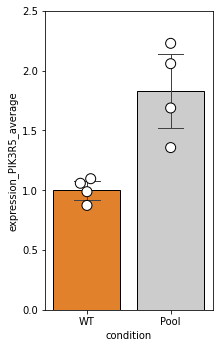

In [142]:
plt.figure(figsize = (3, 5.5))
sns.barplot(data = ct_values, x = 'condition', y = 'expression_PIK3R5_average',
            edgecolor = 'k', capsize = 0.3, errwidth = 1, order = ['WT', 'Pool'], palette = ['#FF7F0E', '#CCCCCC'])
sns.swarmplot(data = ct_values, x = 'condition', y = 'expression_PIK3R5_average',
              edgecolor = 'k', linewidth = 1, color = 'w', size = 10, order = ['WT', 'Pool'])
plt.ylim((0, 2.5))
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/qpcr_quantification.pdf', bbox_inches = 'tight')
plt.show()